
# 02_fix_clean_eda_demand.ipynb
**Date:** 2025-11-07

## Goal
Fix incorrect EDA caused by inconsistent timestamp formats across NESO CSVs.
This notebook:
1. Reads **raw yearly CSVs** from `data/electricity/raw/`.
2. **Detects & harmonizes timestamps** (handles `SETTLEMENT_DATE` + `SETTLEMENT_PERIOD`, combined datetime, separate date/time).
3. Detects a **demand** column and standardizes to `demand_mw`.
4. Writes a **normalized CSV** streaming append: `data/electricity/intermediate/electricity_normalized.csv` with columns `ts,demand_mw`.
5. Loads the normalized file, fixes gaps, **resamples** to 30-min & hourly, fills missing sensibly.
6. Produces correct time-series EDA plots.
7. Exports final cleaned series to **Parquet**: `data/electricity/intermediate/electricity_all_cleaned.parquet`.


In [1]:

# Install into the current kernel
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn pyarrow tqdm --quiet



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

from pathlib import Path
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq

plt.style.use("ggplot")

RAW_DIR = Path("data/electricity/raw")
INT_DIR = Path("data/electricity/intermediate")
RAW_DIR.mkdir(parents=True, exist_ok=True)
INT_DIR.mkdir(parents=True, exist_ok=True)

normalized_csv = INT_DIR / "electricity_normalized.csv"
clean_parquet  = INT_DIR / "electricity_all_cleaned.parquet"


## 1) Helpers to detect timestamp & demand and normalize each file

In [3]:

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (df.columns.str.strip()
                           .str.lower()
                           .str.replace(r"\s+", "_", regex=True)
                           .str.replace(r"[^0-9a-zA-Z_]+", "", regex=True))
    return df

def detect_timestamp_columns(cols):
    """Return a plan dict describing how to construct a timestamp."""
    s = set(cols)
    # Case A: SETTLEMENT_DATE + SETTLEMENT_PERIOD (or similar) -> 48 half-hours
    if {"settlement_date","settlement_period"}.issubset(s):
        return {"kind":"date_period", "date":"settlement_date", "period":"settlement_period"}
    # Case B: combined datetime column
    for c in cols:
        if re.search(r"(datetime|timestamp|date_time|local_time|publishtime|time)", c):
            return {"kind":"combined", "col": c}
    # Case C: separate date & time columns
    date_cand = None
    time_cand = None
    for c in cols:
        if re.search(r"(date)", c) and date_cand is None:
            date_cand = c
        if re.search(r"(time)", c) and time_cand is None:
            time_cand = c
    if date_cand and time_cand:
        return {"kind":"date_plus_time", "date":date_cand, "time":time_cand}
    return None

def detect_demand_column(cols):
    # prefer columns with 'demand' first, fallback to 'mw' or 'tsd'
    demand_like = [c for c in cols if re.search(r"(demand|nd|tsd)", c)]
    mw_like = [c for c in cols if re.search(r"(mw$|_mw$|mw_)", c)]
    for lst in (demand_like, mw_like):
        if lst:
            return sorted(lst, key=len)[0]
    load_like = [c for c in cols if "load" in c]
    return sorted(load_like, key=len)[0] if load_like else None

def build_ts(df, plan):
    """Construct a pandas datetime Series named 'ts' from the plan."""
    if plan["kind"] == "date_period":
        d = pd.to_datetime(df[plan["date"]], errors="coerce")
        p = pd.to_numeric(df[plan["period"]], errors="coerce").astype("Int64")
        ts = d + pd.to_timedelta((p - 1).astype("float") * 30, unit="m")
        return ts
    elif plan["kind"] == "combined":
        return pd.to_datetime(df[plan["col"]], errors="coerce")
    elif plan["kind"] == "date_plus_time":
        d = pd.to_datetime(df[plan["date"]], errors="coerce")
        ts = pd.to_datetime(d.dt.date.astype(str) + " " + df[plan["time"]].astype(str), errors="coerce")
        ts = ts.fillna(d)
        return ts
    else:
        return pd.Series(pd.NaT, index=df.index)

def normalize_one_file(path: Path) -> int:
    """Read a CSV and append normalized rows (ts, demand_mw) to normalized_csv. Returns rows written."""
    rows_written = 0
    header_written = normalized_csv.exists() and normalized_csv.stat().st_size > 0

    hdr = pd.read_csv(path, nrows=0, low_memory=False)
    hdr = normalize_columns(hdr)
    plan = detect_timestamp_columns(hdr.columns)
    demand_col = detect_demand_column(hdr.columns)
    if plan is None or demand_col is None:
        print(f"Skip (no timestamp/demand): {path.name}")
        return 0

    for chunk in pd.read_csv(path, chunksize=200_000, low_memory=False):
        chunk = normalize_columns(chunk)
        ts = build_ts(chunk, plan)
        dem = pd.to_numeric(chunk[demand_col], errors="coerce")
        out = pd.DataFrame({"ts": ts, "demand_mw": dem}).dropna(subset=["ts"])
        out.to_csv(normalized_csv, mode="a", index=False, header=not header_written)
        header_written = True
        rows_written += len(out)
    return rows_written


## 2) Normalize all raw CSVs into one `electricity_normalized.csv`

In [4]:

# if normalized_csv.exists(): normalized_csv.unlink()  # uncomment to reset

files = sorted(RAW_DIR.glob("*.csv"))
assert files, f"No CSV files found in {RAW_DIR}. Did you download them?"

total_rows = 0
for f in tqdm(files, desc="Normalizing CSVs"):
    total_rows += normalize_one_file(f)

print(f"Normalized rows written: {total_rows:,}")
print("Normalized file:", normalized_csv, "size(MB):", round(normalized_csv.stat().st_size/1e6, 2))


Normalizing CSVs:  32%|███▏      | 8/25 [00:00<00:01, 11.90it/s]C:\Users\User\AppData\Local\Temp\ipykernel_23264\1078485582.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d = pd.to_datetime(df[plan["date"]], errors="coerce")
C:\Users\User\AppData\Local\Temp\ipykernel_23264\1078485582.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d = pd.to_datetime(df[plan["date"]], errors="coerce")
Normalizing CSVs:  40%|████      | 10/25 [00:00<00:01, 12.31it/s]C:\Users\User\AppData\Local\Temp\ipykernel_23264\1078485582.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d = 

Normalized rows written: 434,686
Normalized file: data\electricity\intermediate\electricity_normalized.csv size(MB): 11.74


## 3) Load normalized series, fix gaps, resample, fill missing

In [5]:

df = pd.read_csv(normalized_csv, parse_dates=["ts"])
df = df.sort_values("ts")
df = df.groupby("ts", as_index=False)["demand_mw"].mean()

# 30-min grid
df_30 = df.set_index("ts").resample("30T").mean()

# fill missing via time interpolation + edge fill
df_30["demand_mw"] = df_30["demand_mw"].interpolate(method="time").bfill().ffill()

# hourly aggregation
df_H = df_30.resample("H").mean()

print("30-min rows:", len(df_30), "Hourly rows:", len(df_H))


30-min rows: 434688 Hourly rows: 217344


C:\Users\User\AppData\Local\Temp\ipykernel_23264\3758960879.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30 = df.set_index("ts").resample("30T").mean()
C:\Users\User\AppData\Local\Temp\ipykernel_23264\3758960879.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_H = df_30.resample("H").mean()


## 4) Time-series EDA (corrected)

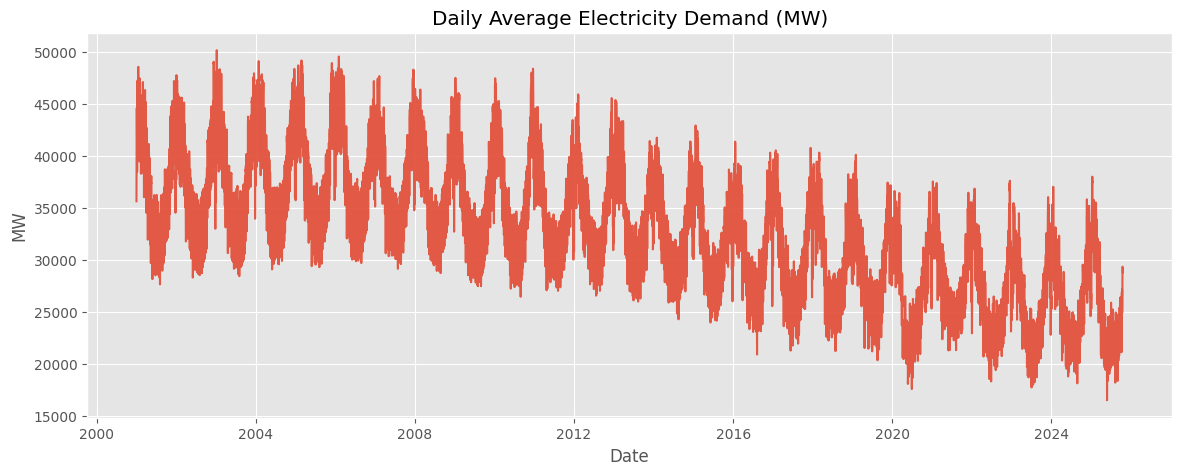

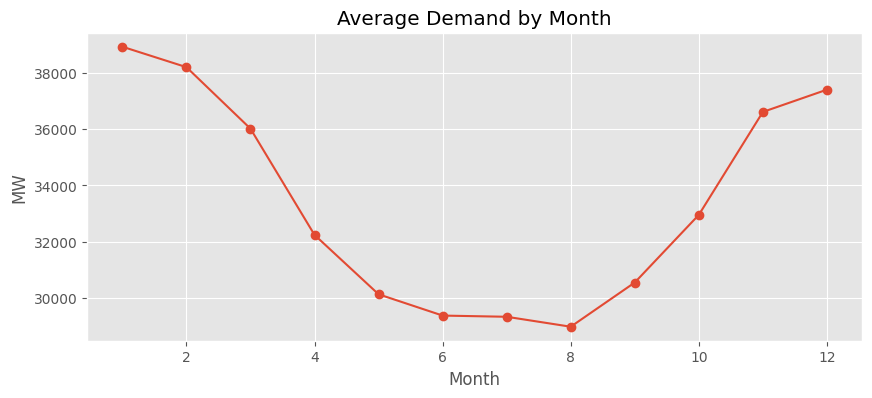

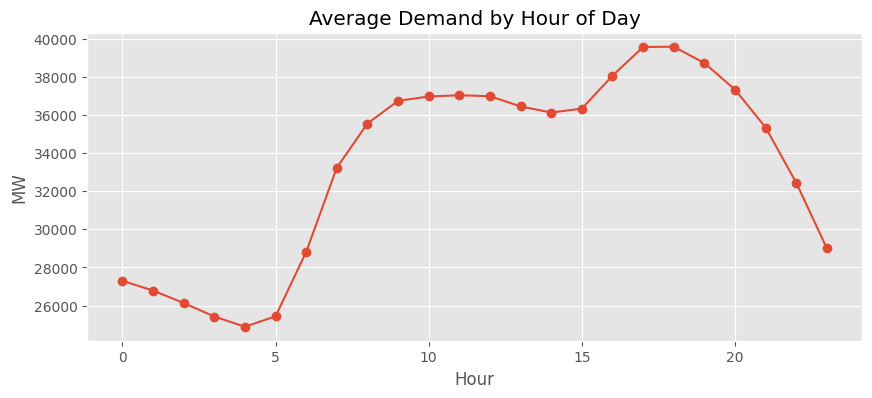

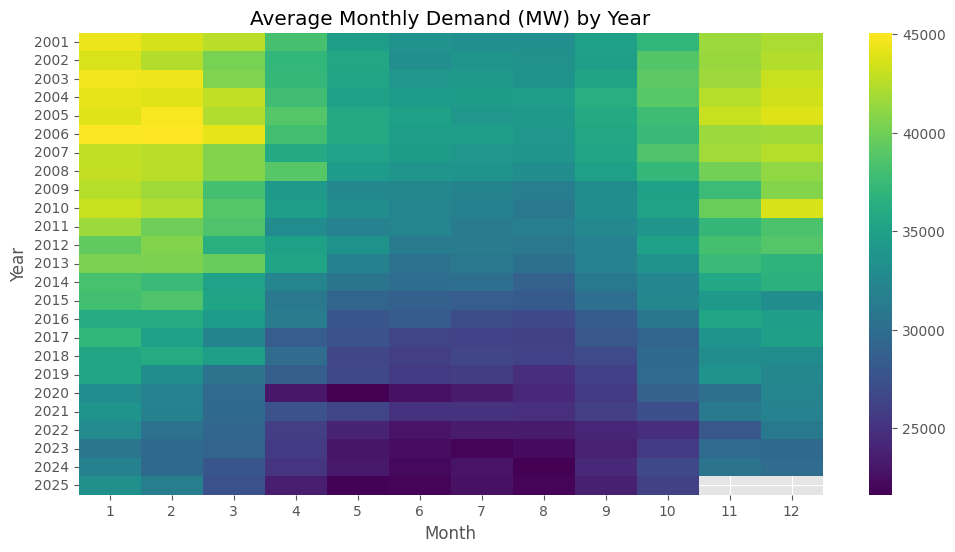

In [6]:

eda = df_H.copy()
eda["year"] = eda.index.year
eda["month"] = eda.index.month
eda["date"] = eda.index.date
eda["hour"] = eda.index.hour

# Daily
daily = eda.groupby("date")["demand_mw"].mean()
plt.figure(figsize=(14,5)); daily.plot(alpha=0.9); plt.title("Daily Average Electricity Demand (MW)"); plt.ylabel("MW"); plt.xlabel("Date"); plt.show()

# Month of year
plt.figure(figsize=(10,4)); eda.groupby("month")["demand_mw"].mean().plot(marker="o"); plt.title("Average Demand by Month"); plt.xlabel("Month"); plt.ylabel("MW"); plt.show()

# Hour of day
plt.figure(figsize=(10,4)); eda.groupby("hour")["demand_mw"].mean().plot(marker="o"); plt.title("Average Demand by Hour of Day"); plt.xlabel("Hour"); plt.ylabel("MW"); plt.show()

# Heatmap year x month
pivot = eda.groupby(["year","month"])["demand_mw"].mean().unstack()
plt.figure(figsize=(12,6)); sns.heatmap(pivot, cmap="viridis"); plt.title("Average Monthly Demand (MW) by Year"); plt.ylabel("Year"); plt.xlabel("Month"); plt.show()


## 5) Export cleaned to Parquet (30-minute granularity)

In [7]:

out = df_30.reset_index().rename(columns={"index":"ts"})
table = pa.Table.from_pandas(out, preserve_index=False)
pq.write_table(table, clean_parquet)
print("Saved cleaned Parquet:", clean_parquet, "rows:", len(out))


Saved cleaned Parquet: data\electricity\intermediate\electricity_all_cleaned.parquet rows: 434688
